# 1. Подключение нужных библиотек

In [2]:
# import cv2   
import numpy as np              # для форматирования матриц изображений
import tensorflow as tf         # для загрузки датасета, построения и обучения нейронной сети
import matplotlib.pyplot as plt # для визуального отображения результатов

# 2. Загрузка датасета 

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

### Описание данных
- X - матрицы изображений со значениями от 0 до 255, обозначающие цвет клетки
- y - числа, ожидаемые результаты отработки нейронной сети

### Разделение данных
- _train - данные для обучения нейронной сети
- _test - данные, с помощью которых будет проводиться отображение точности отработки нейронной сети

### Количество элементов
- _train элементов - 60 000
- _test элементов - 10 000

# 3. Визуализация данных

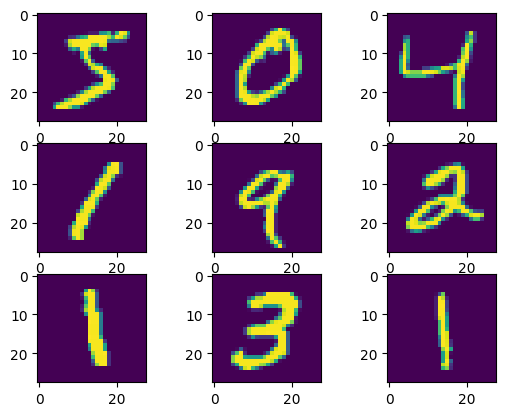

In [4]:
fig, axs = plt.subplots(3, 3)
cnt = 0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X_train[cnt])
        cnt += 1

- В данном коде создается сетка из 9 графиков, в каждый из которых последовательно передаются элементы из массива X_train

# 4. Нормализация данных

In [5]:
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

- Уменьшаем данные до интервала от 0 до 1 для большей скорости подбора весов

# 5. Строим нейронную сеть

In [ ]:
model = tf.keras.models.Sequential() # создали объект нейронной сети


In [ ]:
model.add(tf.keras.layers.Flatten(input_shape=(28,28))) # входной слой

c:\Projects\University\CourseWork\Python\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu)) # 1ый скрытый слой
model.add(tf.keras.layers.Dense(units=128, activation=tf.nn.relu)) # 2ой скрытый слой

In [ ]:
model.add(tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)) # выходной слой

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

- Создали полносвязную модель, состоящую из входного узла, двух скрытых и одного выходного узла

# 6. Компилируем нейронную сеть

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


- Подобрали нужные нам методы для подбора весов, которые вычислят их наиболее быстро и точно

# 7. Тренируем нейронную сеть

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=100)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8280 - loss: 0.6358
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9543 - loss: 0.1558
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9691 - loss: 0.1014
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9785 - loss: 0.0732
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9829 - loss: 0.0566
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9867 - loss: 0.0432
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9900 - loss: 0.0327
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9930 - loss: 0.0258
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9943 - loss: 0.0196
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9959 - loss: 0.0152


- epochs - число полных проходов нейронной сети по всему набору обучающих данных (в нашем случае матрицам изображений чисел) 
- batch_size - кол-во примеров поданных в модель, после которых нейронная сеть будет обновлять веса (позволяет сбалансировать скорость обучения и использования памяти)

# 8. Оценка точности модели 

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(loss)
print(accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9694 - loss: 0.1036
0.095691978931427
0.972000002861023


- На основе тестовых данных определили значение функции потерь и точность модели 

# 9. Использование модели

- Модель предсказывает вероятности принадлежности изображения каждого числа в наборе X_train к каждому числу (от 0 до 9)

In [ ]:
prediction = model.predict([X_test])
prediction

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[3.5888196e-12, 2.8852396e-11, 2.7135849e-09, ..., 9.9999356e-01,
        1.2754926e-09, 7.2750800e-07],
       [3.7099859e-12, 8.0624613e-06, 9.9999130e-01, ..., 5.3456419e-12,
        7.1226125e-08, 3.7063307e-15],
       [8.1832602e-10, 9.9980849e-01, 2.9554417e-07, ..., 8.5711599e-06,
        1.7387133e-04, 1.0120878e-08],
       ...,
       [6.7663351e-15, 7.9100632e-10, 2.6850061e-12, ..., 1.9425501e-09,
        2.5750715e-09, 1.0132319e-06],
       [8.5453994e-10, 3.3998561e-11, 3.8668637e-13, ..., 7.4249096e-10,
        7.4833310e-06, 1.2914733e-12],
       [2.1743470e-10, 2.6060107e-12, 5.0842035e-12, ..., 2.9400717e-15,
        6.4797630e-13, 9.1874149e-15]], dtype=float32)

- Вывод вероятностей принадлежности конкретного изображения к каждому классу чисел
- Вывод числа, к которому вероятность принадлежности модели больше всего 

In [43]:
print('Probabilities: ', prediction[0])
print('\n')
print('Prediction: ', np.argmax(prediction[0]))


Probabilities:  [3.5888196e-12 2.8852396e-11 2.7135849e-09 5.7080351e-06 9.8085611e-12
 3.5133063e-10 3.0328217e-17 9.9999356e-01 1.2754926e-09 7.2750800e-07]


Prediction:  7


- Отрисовка изображения 

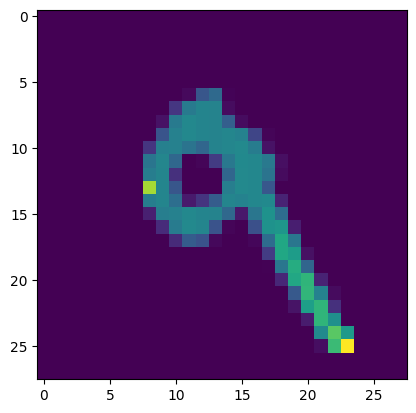

In [34]:
plt.imshow(X_test[7])
plt.show()